Hyperparameters:
H: 5 W: 5 GAMMA: 0.8 ACT_RAND: 0.3 R_MAX: 1.0
N_TRAJS: 100 L_TRAJ: 50 LEARNING_RATE: 0.1
N_ITERS: 200 K: 10


100%|██████████| 9/9 [02:24<00:00, 16.11s/it]


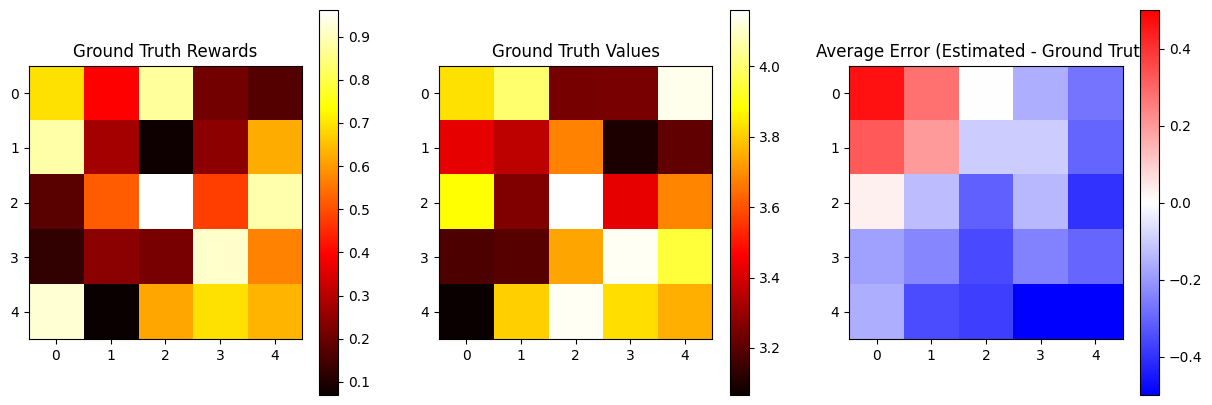

Average MC Error across all cells: -0.1638331460169011
Negative average error indicates a negative bias in estimation.


In [31]:
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import namedtuple
from tqdm import tqdm

Step = namedtuple('Step', 'cur_state action next_state reward done')

# Hyperparameters
H = 5
W = 5
GAMMA = 0.8
ACT_RAND = 0.3
R_MAX = 1.0
N_TRAJS = 100
L_TRAJ = 50
LEARNING_RATE = 0.1
N_ITERS = 200
K = 10  # number of Monte Carlo runs

print("Hyperparameters:")
print("H:", H, "W:", W, "GAMMA:", GAMMA, "ACT_RAND:", ACT_RAND, "R_MAX:", R_MAX)
print("N_TRAJS:", N_TRAJS, "L_TRAJ:", L_TRAJ, "LEARNING_RATE:", LEARNING_RATE)
print("N_ITERS:", N_ITERS, "K:", K)


def normalize(vals):
    mn = np.min(vals)
    mx = np.max(vals)
    if mx == mn:
        return vals
    return (vals - mn) / (mx - mn)


def create_random_reward(H, W):
    # Create random rewards (no particular structure)
    # Uniform random distribution between [0, R_MAX]
    rmap = np.random.rand(H, W) * R_MAX
    return rmap


class GridWorld(object):
    def __init__(self, grid, terminals, trans_prob=1):
        self.height = len(grid)
        self.width = len(grid[0])
        self.n_states = self.height * self.width
        for i in range(self.height):
            for j in range(self.width):
                grid[i][j] = str(grid[i][j])
        self.terminals = terminals
        self.grid = grid
        self.neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0), (0, 0)]
        self.actions = [0, 1, 2, 3, 4]
        self.n_actions = len(self.actions)
        self.trans_prob = trans_prob
        self._cur_state = None

    def get_actions(self, state):
        if self.grid[state[0]][state[1]] == 'x':
            return [4]
        actions = []
        for i in range(self.n_actions - 1):
            inc = self.neighbors[i]
            a = self.actions[i]
            nei_s = (state[0] + inc[0], state[1] + inc[1])
            if 0 <= nei_s[0] < self.height and 0 <= nei_s[1] < self.width and self.grid[nei_s[0]][nei_s[1]] != 'x':
                actions.append(a)
        return actions

    def get_reward(self, state):
        if self.grid[state[0]][state[1]] != 'x':
            return float(self.grid[state[0]][state[1]])
        else:
            return 0

    def is_terminal(self, state):
        return tuple(state) in self.terminals

    def get_transition_states_and_probs(self, state, action):
        if self.is_terminal(tuple(state)):
            return [(tuple(state), 1)]
        if self.trans_prob == 1:
            inc = self.neighbors[action]
            nei_s = (state[0] + inc[0], state[1] + inc[1])
            if 0 <= nei_s[0] < self.height and 0 <= nei_s[1] < self.width and self.grid[nei_s[0]][nei_s[1]] != 'x':
                return [(nei_s, 1)]
            else:
                return [(state, 1)]
        else:
            mov_probs = np.zeros([self.n_actions])
            mov_probs[action] = self.trans_prob
            mov_probs += (1 - self.trans_prob) / self.n_actions
            for a in range(self.n_actions):
                inc = self.neighbors[a]
                nei_s = (state[0] + inc[0], state[1] + inc[1])
                if nei_s[0] < 0 or nei_s[0] >= self.height or nei_s[1] < 0 or nei_s[1] >= self.width or self.grid[int(nei_s[0])][int(nei_s[1])] == 'x':
                    mov_probs[self.n_actions - 1] += mov_probs[a]
                    mov_probs[a] = 0
            res = []
            for a in range(self.n_actions):
                if mov_probs[a] != 0:
                    inc = self.neighbors[a]
                    nei_s = (state[0] + inc[0], state[1] + inc[1])
                    res.append((nei_s, mov_probs[a]))
            return res

    def reset(self, start_pos):
        self._cur_state = start_pos

    def get_current_state(self):
        return self._cur_state

    def step(self, action):
        if self.is_terminal(self._cur_state):
            return self._cur_state, action, self._cur_state, self.get_reward(self._cur_state), True
        st_prob = self.get_transition_states_and_probs(self._cur_state, action)
        probs = [p for st, p in st_prob]
        sampled_idx = np.random.choice(np.arange(0, len(st_prob)), p=probs)
        last_state = self._cur_state
        next_state = st_prob[sampled_idx][0]
        reward = self.get_reward(last_state)
        self._cur_state = next_state
        return last_state, action, next_state, reward, self.is_terminal(next_state)

    def get_transition_mat(self):
        N_STATES = self.height * self.width
        N_ACTIONS = len(self.actions)
        P_a = np.zeros((N_STATES, N_STATES, N_ACTIONS))
        for si in range(N_STATES):
            posi = self.idx2pos(si)
            for a in range(N_ACTIONS):
                probs = self.get_transition_states_and_probs(posi, a)
                for posj, prob in probs:
                    sj = self.pos2idx(posj)
                    P_a[si, sj, a] = prob
        return P_a

    def pos2idx(self, pos):
        return pos[0] + pos[1] * self.height

    def idx2pos(self, idx):
        return (idx % self.height, idx // self.height)


def value_iteration(P_a, rewards, gamma, error=0.01, deterministic=True):
    N_STATES, _, N_ACTIONS = np.shape(P_a)
    values = np.zeros([N_STATES])
    while True:
        values_tmp = values.copy()
        for s in range(N_STATES):
            values[s] = max([sum([P_a[s, s1, a] * (rewards[s] + gamma * values_tmp[s1]) for s1 in range(N_STATES)]) for a in range(N_ACTIONS)])
        diff = max([abs(values[s] - values_tmp[s]) for s in range(N_STATES)])
        if diff < error:
            break
    if deterministic:
        policy = np.zeros([N_STATES])
        for s in range(N_STATES):
            action_values = [sum([P_a[s, s1, a] * (rewards[s] + gamma * values[s1]) for s1 in range(N_STATES)]) for a in range(N_ACTIONS)]
            policy[s] = np.argmax(action_values)
        return values, policy
    else:
        policy = np.zeros([N_STATES, N_ACTIONS])
        for s in range(N_STATES):
            v_s = np.array([sum([P_a[s, s1, a] * (rewards[s] + gamma * values[s1]) for s1 in range(N_STATES)]) for a in range(N_ACTIONS)])
            policy[s, :] = v_s / np.sum(v_s)
        return values, policy


def compute_state_visition_freq(P_a, gamma, trajs, policy, deterministic=True):
    N_STATES, _, N_ACTIONS = np.shape(P_a)
    T = len(trajs[0])
    mu = np.zeros([N_STATES, T])
    for traj in trajs:
        mu[traj[0].cur_state, 0] += 1
    mu[:, 0] = mu[:, 0] / len(trajs)
    for s in range(N_STATES):
        for t in range(T - 1):
            if deterministic:
                mu[s, t + 1] = sum([mu[ps, t] * P_a[ps, s, int(policy[ps])] for ps in range(N_STATES)])
            else:
                mu[s, t + 1] = sum([sum([mu[ps, t] * P_a[ps, s, a] * policy[ps, a] for a in range(N_ACTIONS)]) for ps in range(N_STATES)])
    freq = np.sum(mu, 1)
    return freq


def maxent_irl(feat_map, P_a, gamma, trajs, lr, n_iters):
    N_STATES, _, N_ACTIONS = np.shape(P_a)
    theta = np.random.uniform(size=(feat_map.shape[1],))
    feat_exp = np.zeros([feat_map.shape[1]])
    for episode in trajs:
        for step in episode:
            feat_exp += feat_map[step.cur_state, :]
    feat_exp = feat_exp / len(trajs)

    for iteration in range(n_iters):
        rewards = np.dot(feat_map, theta)
        _, policy = value_iteration(P_a, rewards, gamma, error=0.01, deterministic=False)
        svf = compute_state_visition_freq(P_a, gamma, trajs, policy, deterministic=False)
        grad = feat_exp - feat_map.T.dot(svf)
        theta += lr * grad
    rewards = np.dot(feat_map, theta)
    return normalize(rewards)


def generate_demonstrations(gw, policy, n_trajs=100, len_traj=20):
    trajs = []
    for i in range(n_trajs):
        gw.reset([0, 0])
        episode = []
        s = gw.pos2idx([0, 0])
        for _t in range(len_traj):
            if policy.ndim == 1:
                a = int(policy[s])
            else:
                a = np.random.choice(range(policy.shape[1]), p=policy[s])
            cs, act, ns, r, done = gw.step(a)
            episode.append(Step(cur_state=gw.pos2idx(cs), action=act, next_state=gw.pos2idx(ns), reward=r, done=done))
            s = gw.pos2idx(ns)
            if done:
                break
        trajs.append(episode)
    return trajs


def run_simulation():
    # Use random rewards instead of normal to remove any structure
    rmap_gt = create_random_reward(H, W)
    gw = GridWorld(rmap_gt, {}, 1 - ACT_RAND)
    rewards_gt = np.reshape(rmap_gt, H * W, order='F')
    P_a = gw.get_transition_mat()
    values_gt, policy_gt = value_iteration(P_a, rewards_gt, GAMMA, error=0.01, deterministic=False)
    feat_map = np.eye(H * W)
    trajs = generate_demonstrations(gw, policy_gt, n_trajs=N_TRAJS, len_traj=L_TRAJ)
    rewards_est = maxent_irl(feat_map, P_a, GAMMA, trajs, LEARNING_RATE, N_ITERS)
    error_map = rewards_est.reshape(H, W) - rmap_gt
    return rmap_gt, values_gt, error_map


def main():
    rmap_gt, values_gt, error_map = run_simulation()
    errors_accum = error_map.copy()

    # Now run K-1 more times for Monte Carlo
    for _ in tqdm(range(K - 1)):
        _, _, error_map = run_simulation()
        errors_accum += error_map

    avg_error_map = errors_accum / K
    avg_error = np.mean(avg_error_map)

    # final grid of graphs: GT rewards, GT values, avg error map
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(rmap_gt, interpolation='nearest', cmap='hot')
    plt.title('Ground Truth Rewards')
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(values_gt.reshape(H, W), interpolation='nearest', cmap='hot')
    plt.title('Ground Truth Values')
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(avg_error_map, interpolation='nearest', cmap='bwr', vmin=-0.5, vmax=0.5)
    plt.title('Average Error (Estimated - Ground Truth)')
    plt.colorbar()
    plt.show()

    # Print average MC error across all cells
    print("Average MC Error across all cells:", avg_error)
    if avg_error > 0:
        print("Positive average error indicates a positive bias in estimation.")
    elif avg_error < 0:
        print("Negative average error indicates a negative bias in estimation.")
    else:
        print("Average error is zero, no bias detected.")


if __name__ == "__main__":
    main()
